# 데이터 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

path = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

In [ ]:
priors = pd.read_csv(path + 'order_products__prior.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1
train = pd.read_csv(path + 'order_products__train.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,   # 1 ~ 80
            'reordered': np.uint8})         # 0 ~ 1
orders = pd.read_csv(path + 'orders.csv', dtype={
        'order_id': np.uint32,              # 1 ~ 3421083
        'user_id': np.uint32,               # 1 ~ 206209
        'eval_set': 'category',             
        'order_number': np.uint8,           # 1 ~ 100
        'order_dow': np.uint8,              # 0 ~ 6 
        'order_hour_of_day': np.uint8,      # 0 ~ 23
        'days_since_prior_order': np.float32})
products = pd.read_csv(path + 'products.csv', dtype={
        'product_id': np.uint16,     # 1 ~ 49688
        'order_id': np.uint32,
        'aisle_id': np.uint8,        # 1 ~ 134
        'department_id': np.uint8}) # 1 ~ 21

# 1. Orders

모든 주문 정보를 확인할 수 있다.

- order_id : 주문 번호, (순서가 없는 범주형)

    총 3,421,083개의 주문이 있다.

- user_id : 고객 번호, (순서가 없는 범주형)

    총 206,209명의 데이터

- eval_set : 데이터 구분, (순서가 없는 범주형)

    prior, train, test로 구분. 

    - prior : 고객별 마지막 주문을 제외한 모든 주문

    - train : 131,209명의 마지막 주문. 주문별 구매 내역이 있다.

    - test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

- order_number : 해당 고객의 몇 번째 주문인지, (순서가 있는 범주형)

    최소 주문 수는 4건, 최대 주문 수는 100건이다. 

- order_dow : 주문 요일

- order_hour_of_day : 주문 시간

- days_since_prior_order : 이전 주문과의 간격 (일). 최대 30일이다.

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## 결측치 확인

In [ ]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

days_since_prior_order에 206,209 건의 결측치가 있다. 첫번째 주문은 이전 주문이 없기 때문에 모든 고객의 수만큼 결측치가 있다.

## order_id

주문 번호

In [ ]:
print(f"총 주문 수 : {orders.order_id.nunique()}")

총 주문 수 : 3421083


## user_id

고객 번호

In [ ]:
print(f"총 고객 수 : {orders.user_id.nunique()}")

총 고객 수 : 206209


In [ ]:
orders.user_id.value_counts().min(), orders.user_id.value_counts().max()

(4, 100)

## eval_set

데이터 구분

prior, train, test로 구분.

- prior : 고객별 마지막 주문을 제외한 모든 주문

- train : 131,209명의 마지막 주문. 주문별 구매 내역이 있다.

- test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


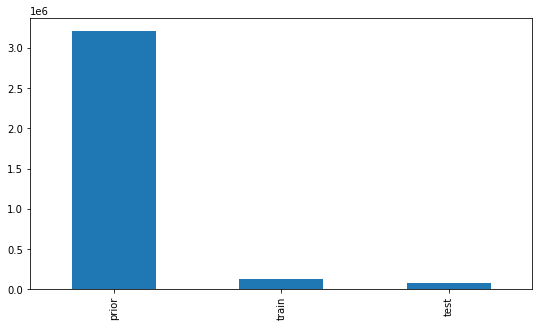

In [ ]:
print(orders.eval_set.value_counts())
plt.figure(figsize=(9, 5))
orders.eval_set.value_counts().plot.bar()
plt.show()

## order_number

해당 고객의 몇 번째 주문인지 알 수 있다. 

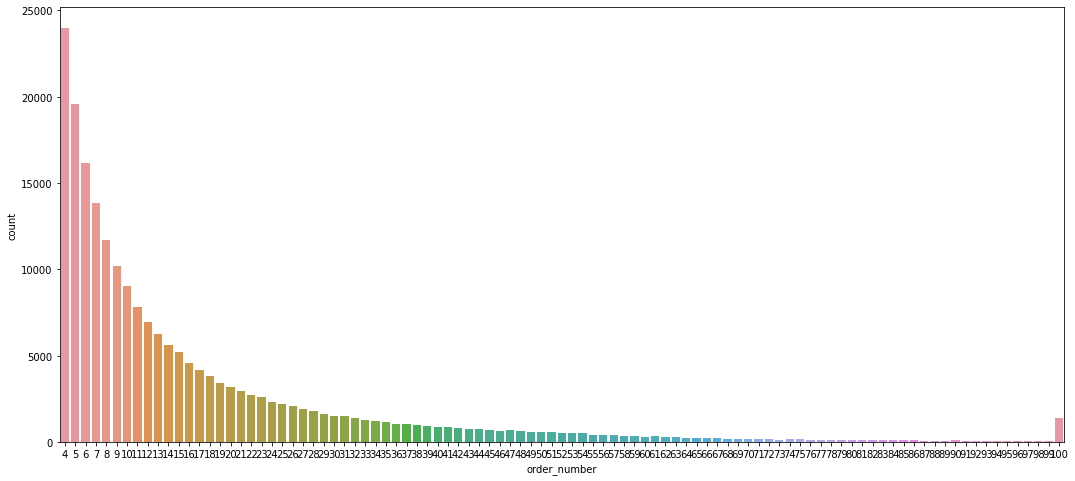

In [ ]:
plt.figure(figsize=(18, 8))
data = orders.groupby('user_id')['order_number'].max().reset_index()
sns.countplot(x='order_number', data=data)
plt.show()

In [ ]:
orders.groupby('user_id')['order_number'].max().describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

최소 주문 수는 4건, 최대 주문 수는 100건이다. 고객 평균 주문 수는 16건, 중앙값은 10이다.

4회 주문한 고객이 가장 많다.

## order_dow

주문 요일

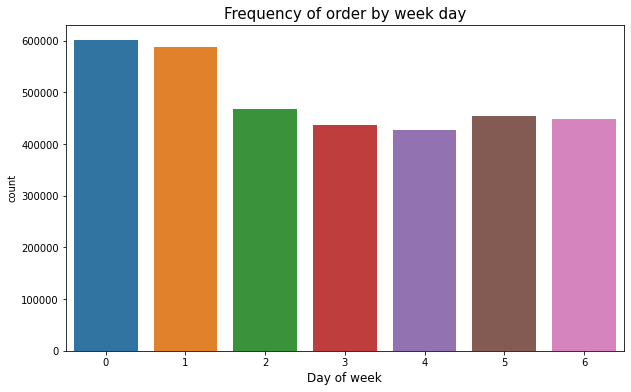

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_dow', data=orders)
plt.title("Frequency of order by week day", fontsize=15)
plt.xlabel('Day of week', fontsize=12)
plt.show()

In [ ]:
round(orders.order_dow.value_counts()[:2].mean() / orders.order_dow.value_counts()[2:].mean(), 2)

1.33

0은 토요일, 1은 일요일이다. 주말이 평일에 비해서 주문 수가 약 33%가 많다.

## order_hour_of_day

주문 시간

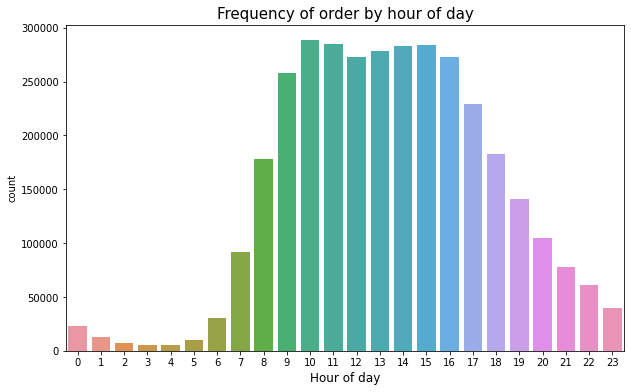

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_hour_of_day', data=orders)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.xlabel('Hour of day', fontsize=12)
plt.show()

낮 시간대에 주문이 많은 것을 볼 수 있다. 

### 요일 x 시간

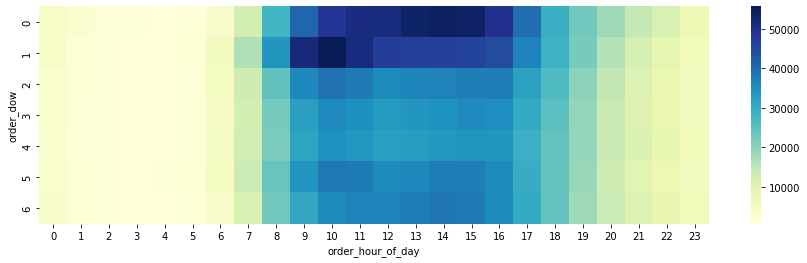

In [ ]:
plt.figure(figsize=(15, 4))
data = orders.groupby(['order_dow', 'order_hour_of_day'])['order_number'].count().reset_index().pivot('order_dow','order_hour_of_day','order_number')
sns.heatmap(data, cmap="YlGnBu")
plt.show()

요일과 시간별 주문 수를 확인해보면 가장 주문이 많은 시간대는 일요일 오전이다. 
평일에 비하면 주말이 확연히 주문량이 많은 것을 볼 수 있다. 토요일은 오후, 일요일은 오전에 주문이 가장 많은 것을 확인할 수 있다.
토요일은 모든 요일 중에서 가장 늦은 시간까지 주문이 일어난다. 
평일을 보면 화요일과 수요일이 비교적 주문이 적은 것을 볼 수 있다.


## days_since_prior_order

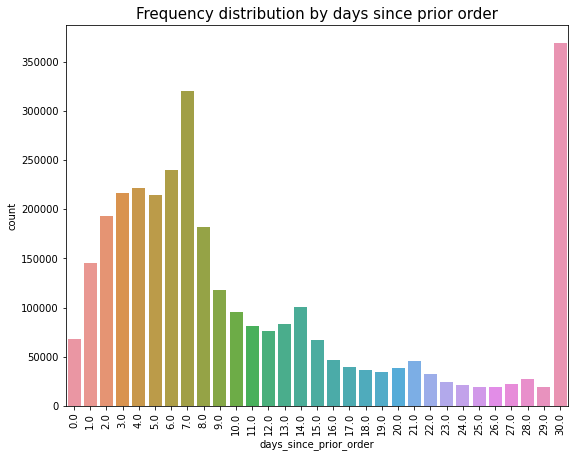

In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(x='days_since_prior_order', data=orders)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

30일 이상 간격의 주문이 가장 많다. 7일 간격으로 (7, 14, 21, 28) 주문량이 튀는 것을 확인할 수 있다.

# 2. priors

마지막 주문을 제외한 모든 주문 별로 구매 내역을 확인할 수 있다. 

총 판매된 제품의 수는 32,434,489개다.

- order_id : 주문 번호

- product_id : 제품 번호 

    총 49,677 종의 제품이 있다.

- add_to_cart_order : 제품이 장바구니에 담긴 순서

- reordered : 재구매 여부

In [ ]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


- 제품 정보 추가

제품에 aisle정보와 department정보를 추가한다.

In [ ]:
aisles = pd.read_csv(path + 'aisles.csv', dtype={
    'aisle_id': np.uint8
})
departments = pd.read_csv(path + 'departments.csv', dtype={
    'department_id': np.uint8
})

In [ ]:
products_ad = pd.merge(products, aisles)
products_ad = pd.merge(products_ad, departments).sort_values('product_id').reset_index(drop=True)
products_ad = products_ad[['product_id', 'product_name', 'aisle_id', 'aisle', 'department_id', 'department']]
del aisles, departments
priors_prod = pd.merge(priors, products_ad).sort_values('order_id').reset_index(drop=True)
priors_prod.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,aisle,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,eggs,16,dairy eggs
1,2,45918,4,1,Coconut Butter,19,oils vinegars,13,pantry
2,2,30035,5,0,Natural Sweetener,17,baking ingredients,13,pantry
3,2,17794,6,1,Carrots,83,fresh vegetables,4,produce
4,2,9327,3,0,Garlic Powder,104,spices seasonings,13,pantry


## 주문 정보

### 주문 당 구매 제품 수

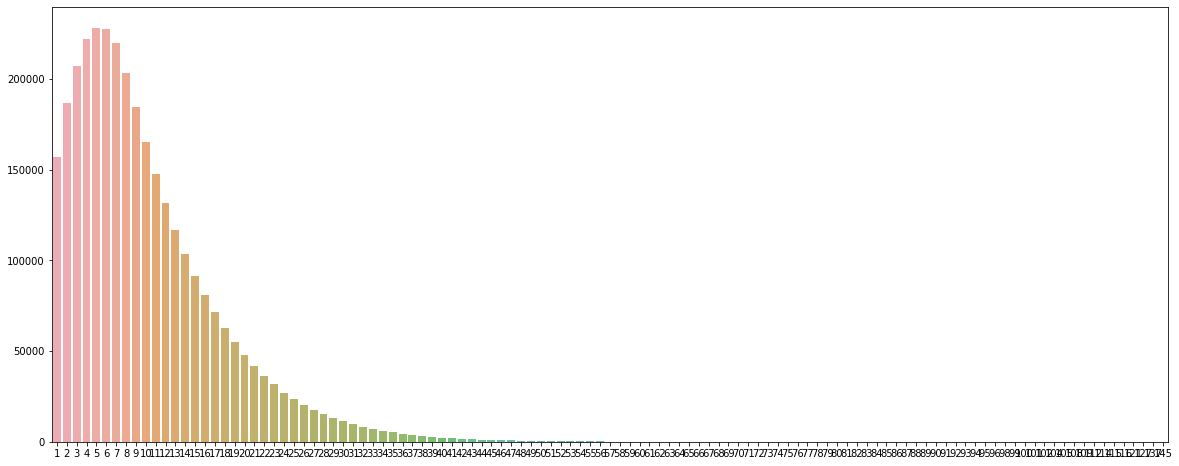

In [ ]:
data = priors_prod.groupby('order_id')['add_to_cart_order'].max()
plt.figure(figsize=(20,8))
sns.barplot(data.index, data.values, alpha=0.8)
plt.show()

In [ ]:
data.describe().astype(np.uint32)

count    3214874
mean          10
std            7
min            1
25%            5
50%            8
75%           14
max          145
Name: add_to_cart_order, dtype: uint32

주문 당 구매 제품 수는 평균 10개다. 

### 주문 별 재주문 제품 포함 비율


In [ ]:
(priors_prod.groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / priors_prod.order_id.nunique()

1    0.879151
0    0.120849
Name: reordered, dtype: float64

단 12%의 주문만 재주문 제품이 없는 주문이다. 고객이 주문한 제품일 수록 재주문할 확률이 높다고 할 수 있다. 

(주문 별로 재주문 제품 포함 여부를 피쳐로 만들어서 추가할 수 있다.) 

## 제품 정보

### 총 팔린 제품 종류

In [ ]:
print(f"총 팔린 제품 종류 : {priors_prod.product_id.nunique()}종")

총 팔린 제품 종류 : 49677종


### 가장 많이 팔린 제품 (Top 20)

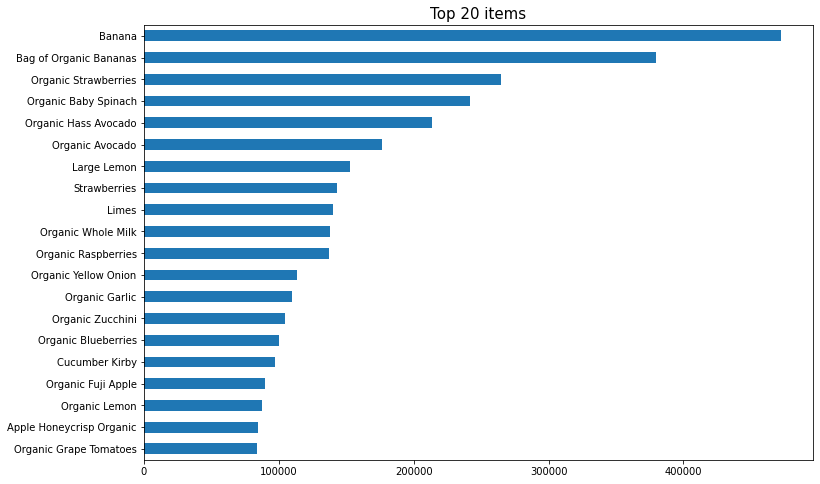

In [ ]:
plt.figure(figsize=(12, 8))
priors_prod.product_name.value_counts().head(20).sort_values().plot.barh()
plt.title('Top 20 items', fontsize=15)
plt.show()

바나나가 가장 많이 팔렸다. 1,2위 모두 바나나다. Organic 제품이 상위권에 많이 분포한 것을 알 수 있다. 대다수의 제품이 과일, 채소다.

### 재구매 여부

In [ ]:
print(f"총 판매 제품 수 : {priors_prod.shape[0]}")
print(f"재구매 제품 수 : {priors_prod.reordered.sum()}")
print(f"재구매 제품 비율 : {(priors_prod.reordered.sum() / priors_prod.shape[0]) * 100:.1f}%")

총 판매 제품 수 : 32434489
재구매 제품 수 : 19126536
재구매 제품 비율 : 59.0%


판매된 모든 제품 중 59%의 제품이 재주문된 제품이다.

### 제품별 재구매율


In [ ]:
data = priors_prod.groupby('product_id')['reordered'].sum() / priors_prod.product_id.value_counts()
data = data.sort_values(ascending=False)
data.describe()

count    49677.000000
mean         0.366461
std          0.208103
min          0.000000
25%          0.208075
50%          0.376623
75%          0.529307
max          0.941176
dtype: float64

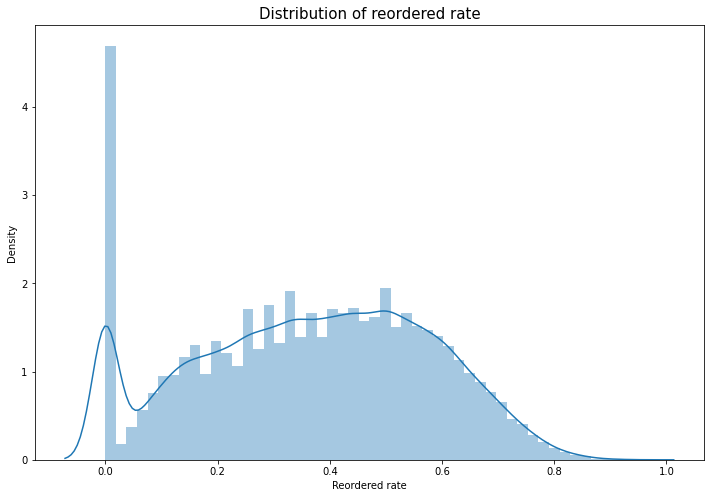

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(data, kde=True)
plt.title('Distribution of reordered rate', fontsize=15)
plt.xlabel('Reordered rate')
plt.show()

### 장바구니에 담긴 순서 별 재구매 율

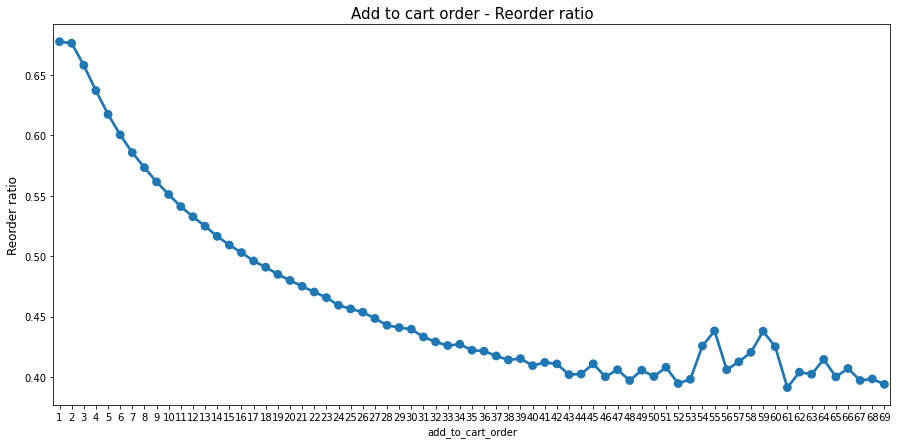

In [ ]:
data = priors_prod[priors_prod['add_to_cart_order'] < 70].groupby('add_to_cart_order')['reordered'].mean()

plt.figure(figsize=(15, 7))
sns.pointplot(data.index, data.values)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.ylabel('Reorder ratio', fontsize=12)
plt.show()

장바구니에 담긴 순서에 따라서 정말 정직하게 재구매율이 떨어지는 것을 확인할 수 있다. 

장바구니 우선순위가 높을 수록 재구매율이 높다고 확실하게 말할 수 있다.

# 제품 정보 추가

## 제품별 총 팔린 수, 재주문 수, 재주문 율 생성

In [ ]:
prods = pd.DataFrame()
prods['orders'] = priors.product_id.value_counts().sort_index().astype(np.uint16)
prods['reorders'] = priors.groupby('product_id')['reordered'].sum().astype(np.uint16)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
# prods['mean_cart_order'] = priors.groupby('product_id')['add_to_cart_order'].mean() # 아직 불확실
prods = prods.reset_index().rename(columns={'index':'product_id'})
prods.head()

,product_id,orders,reorders,reorder_rate,mean_cart_order
0,1,1852,1136,0.613391,5.801836
1,2,90,12,0.133333,9.888889
2,3,277,203,0.732852,6.415162
3,4,329,147,0.446809,9.507599
4,5,15,9,0.600000,6.466667


In [ ]:
products_ad.shape, prods.shape

((49688, 9), (49677, 5))

총 49688개의 제품 중에서 11개의 제품은 팔린 적이 없다. 

생성한 feature를 products에 추가한다. 

In [ ]:
products_ad = pd.merge(products_ad, prods, how='outer')
del prods
products_ad.head()

,product_id,product_name,aisle_id,aisle,department_id,department,orders,reorders,reorder_rate
0,1,Chocolate Sandwich Cookies,61,cookies cakes,19,snacks,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,spices seasonings,13,pantry,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,tea,7,beverages,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,frozen meals,1,frozen,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,marinades meat preparation,13,pantry,15.0,9.0,0.600000


In [ ]:
products_ad[products_ad['orders'].isnull()]

,product_id,product_name,aisle_id,aisle,department_id,department,orders,reorders,reorder_rate
3629,3630,Protein Granola Apple Crisp,57,granola,14,breakfast,NaN,NaN,NaN
3717,3718,Wasabi Cheddar Spreadable Cheese,21,packaged cheese,16,dairy eggs,NaN,NaN,NaN
7044,7045,Unpeeled Apricot Halves in Heavy Syrup,88,spreads,13,pantry,NaN,NaN,NaN
25382,25383,Chocolate Go Bites,61,cookies cakes,19,snacks,NaN,NaN,NaN
27498,27499,Non-Dairy Coconut Seven Layer Bar,100,missing,21,missing,NaN,NaN,NaN
36232,36233,Water With Electrolytes,100,missing,21,missing,NaN,NaN,NaN
37702,37703,Ultra Sun Blossom Liquid 90 loads Fabric Enhan...,75,laundry,17,household,NaN,NaN,NaN
43724,43725,Sweetart Jelly Beans,100,missing,21,missing,NaN,NaN,NaN
45970,45971,12 Inch Taper Candle White,101,air fresheners candles,17,household,NaN,NaN,NaN
46624,46625,Single Barrel Kentucky Straight Bourbon Whiskey,31,refrigerated,7,beverages,NaN,NaN,NaN


팔린 적 없는 11개의 제품에는 생성한 정보가 없기 때문에 결측치가 생기게 된다.

(이 제품들을 날려버려야 할지 선택)

In [ ]:
data = priors_prod.groupby('product_name')['add_to_cart_order'].sum() / priors_prod.product_name.value_counts()
data.sort_values()

Chocolate Peppermint Tart                                                               1.000000
Easter Basket                                                                           1.000000
American Blend                                                                          1.000000
Spicy Falafel                                                                           1.000000
Indoor & Outdoor Allergies, Allergy & Congestion, 24 Hour, Extended Release Tablets     1.000000
                                                                                         ...    
Jalapeno Babies                                                                        36.666667
Eczema Control                                                                         41.000000
Vanilla Bean Sheep Milk Ice Cream                                                      46.000000
Strawberry Energy Gel                                                                  50.000000
Citronge Extra Fine Orange Liq

In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(x= , data=data)
# plt.xticks(rotation='vertical')
# plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

KeyError: ignored

<Figure size 648x504 with 0 Axes>

# 새 섹션